# Signal Processing

I'm a cellular electrophysiologist, which simply means I'm a weird mix between an electrical engineer and a biochemist. I apply various drugs to neurons to see how it changes their electrical activity. Depending on the type of experiment you are running, this data can be very easy to analyze (action potential frequency) or it can be significantly more challenging (burst detection). 

A few years ago I had a problem: neither I nor anyone in my lab knew how to properly analyze some data I had collected. So, I asked an old mentor for some advice on signal processing and dove head first into writing my first data analysis script.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

# I like my style sheet, so sue me
plt.style.use('estep_style')

# Make some data to play with and load it into a pandas dataframe
(I originally used real data, but it's honestly way easier to generalize what I'm doing with mock data)

I'll construct a mock current-clamp (voltage) recording with the following properties:
* 10 seconds long
* Sampling rate of 10 kHz
* 10 Hz + noise oscillation for the first half of the mock recording
* 5 Hz + noise oscillation for the second half

In [2]:
x     = np.arange(0,5,0.0001)
noise = (25 * np.random.randn(len(x)))

large_slow    = (10 * np.sin(20 * np.pi * x))
first_half    = np.array(large_slow + noise)
larger_slower = (15 * np.sin(10 * np.pi * x))
second_half   = np.array(larger_slower + noise)

x = np.arange(0,10,0.0001)
y = np.concatenate((first_half,second_half))

data_dict = {'time':x,'voltage':y}
df = pd.DataFrame(data_dict)
df.head(3)

,time,voltage
0,0.0000,7.263535
1,0.0001,29.827188
2,0.0002,17.233403


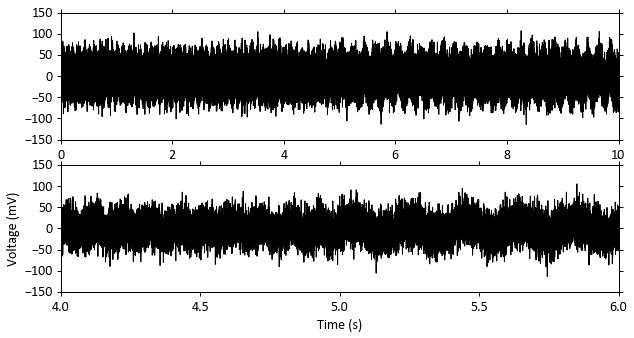

In [3]:
# Plot it just to make sure everything looks as it should
# Full plot and zoomed

f, ax = plt.subplots(2)
ax[0].plot(df['time'], df['voltage'])
ax[1].plot(df['time'][40000:60000],df['voltage'][40000:60000])
ax[1].set_ylabel('Voltage (mV)')
ax[1].set_xlabel('Time (s)')
plt.show()

# So... What are we doin'?
- I need to quantify the waveform by taking the spectral density

#### _Problem_: 
- Getting the spectral density requires collapsing the time domain
- I care about when changes happen...

#### _Solution_: 
Break the signal into overlapping epochs, and run a periodogram on each to gain some time component back (note: I made a similar function to do this with a custom IO and analysis package)

In [4]:
window       = 10000
step         = 5000
rows         = len(df)
epoch_arrays = []
epoch_names  = []
num_epochs   = int(1 + (rows - window) / step)

for i in range(num_epochs):
    epoch_names.append('epoch' + str(i + 1).zfill(3))
    epoch_arrays.append(df[(0 + step * i):(window + step * i)])
    
epoch_df = pd.concat(epoch_arrays, keys=epoch_names)
epoch_df.head(3)

time    voltage
epoch001 0  0.0000   7.263535
         1  0.0001  29.827188
         2  0.0002  17.233403

## And now I perform the periodogram on each epoch and store the values in a new dataframe
Note: I know periodograms are not necessarily the best way to estimate the spectral density, but it is in this particular case due to the short windows coupled with the need for high(ish) resolution and no need for averaging (averaging is bad here).

In [5]:
fs = 10e3
periodogram_dict = {}

for epoch, data in epoch_df.groupby(level=0):
    periodogram_f, periodogram_den = sp.signal.periodogram(epoch_df['voltage'].ix[str(epoch)], fs)
    periodogram_dict[str(epoch)] = dict(zip(periodogram_f, periodogram_den))
    
periodogram_df = pd.DataFrame(periodogram_dict)
periodogram_df.tail(2)

,epoch001,epoch002,epoch003,epoch004,epoch005,epoch006,epoch007,epoch008,epoch009,epoch010,epoch011,epoch012,epoch013,epoch014,epoch015,epoch016,epoch017,epoch018,epoch019
4999,0.138620,0.255251,0.065160,0.052790,0.105504,0.239749,0.134381,0.157702,0.006945,0.147706,0.138620,0.255251,0.065160,0.052790,0.105504,0.239749,0.134381,0.157702,0.006945
5000,0.043236,0.006129,0.036571,0.000552,0.026574,0.088951,0.045812,0.040037,0.033314,0.002677,0.043236,0.006129,0.036571,0.000552,0.026574,0.088951,0.045812,0.040037,0.033314


## And finally, plot the results to see if it's what we expected

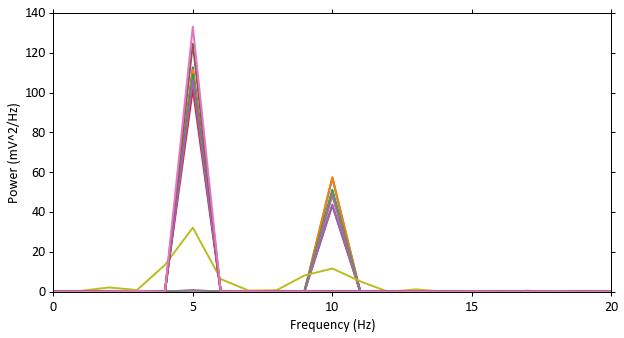

In [6]:
f, ax = plt.subplots(1)
ax.plot(periodogram_df[:20], linewidth=2)
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_xlabel('Frequency (Hz)')
plt.show()

# Now let's look at the variance of the signal in the biologically significant frequency range of the dopaminergic cells I study

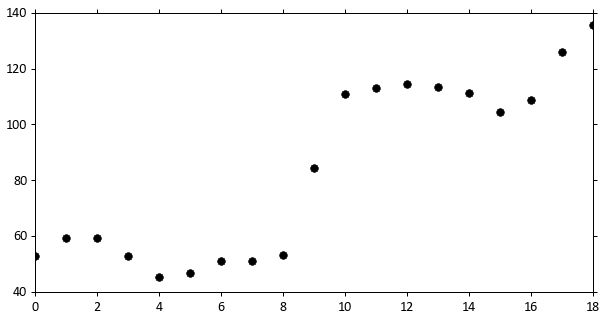

In [7]:
plt.plot(periodogram_df[:20].sum(), marker='.', markersize=15, linestyle='')
plt.show()